In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from tensorflow.keras import backend as K
import tensorflow as tf 
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from keras.datasets.mnist import load_data
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from tensorflow.python.keras.utils import conv_utils

#epsilon set according to BIGGAN https://arxiv.org/pdf/1809.11096.pdf

def _l2normalizer(v, epsilon=1e-4):
    return v / (K.sum(v**2)**0.5 + epsilon)


def power_iteration(W, u, rounds=1):
    '''
    Accroding the paper, we only need to do power iteration one time.
    '''
    _u = u

    for i in range(rounds):
        _v = _l2normalizer(K.dot(_u, W))
        _u = _l2normalizer(K.dot(_v, K.transpose(W)))

    W_sn = K.sum(K.dot(_u, W) * _v)
    return W_sn, _u, _v

"""
Convolution 2D with spectral normalization
"""
class SNConv2D(Conv2D):
    def __init__(self, filters, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2D, self).__init__(filters, **kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.

        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2D, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-1], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):

        outputs = K.conv2d(inputs,
                           self.compute_spectral_normal(training=training),
                           strides=self.strides, padding=self.padding,
                           data_format=self.data_format,
                           dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2D, self).compute_output_shape(input_shape)

"""
Transposed Convolution 2D with spectral normalization
"""
class SNConv2DTranspose(Conv2DTranspose):
    def __init__(self, spectral_normalization=True, **kwargs):
        self.spectral_normalization = spectral_normalization
        super(SNConv2DTranspose, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.u = self.add_weight(name='u', shape=(1, self.filters),
                                 initializer='uniform', trainable=False)
        super(SNConv2DTranspose, self).build(input_shape)
        # Be sure to call this at the end

    def compute_spectral_normal(self, training=True):
        # Spectrally Normalized Weight
        if self.spectral_normalization:
            # Get kernel tensor shape [kernel_h, kernel_w, in_channels, out_channels]
            W_shape = self.kernel.shape.as_list()

            # Flatten the Tensor
            # [out_channels, N]
            W_mat = K.reshape(self.kernel, [W_shape[-2], -1])

            W_sn, u, v = power_iteration(W_mat, self.u)

            if training:
                # Update estimated 1st singular vector
                self.u.assign(u)

            return self.kernel / W_sn
        else:
            return self.kernel

    def call(self, inputs, training=None):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        out_pad_h = out_pad_w = None

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_output_length(
            height, kernel_h, self.padding, stride=stride_h)
        out_width = conv_utils.deconv_output_length(
            width, kernel_w, self.padding, stride=stride_w)
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        outputs = K.conv2d_transpose(
            inputs,
            self.compute_spectral_normal(training=training),
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format
        )

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias,
                                 data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return super(SNConv2DTranspose, self).compute_output_shape(input_shape)

    
    
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=3): # HERE
    # label input
    in_label = Input(shape=(3,)) # HERE
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 3))(li) # HERE
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    
    # downsample
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = SNConv2D(128, kernel_size=4, strides=(2,2), padding='same',kernel_initializer="orthogonal", spectral_normalization=True)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim, n_classes=3): # HERE,  TO TEST WITH SAME NUMBER OF ATTR INSTEAD 2
    # label input
    in_label = Input(shape=(3,)) # HERE, 
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label) # TO TEST WITH SAME NUMBER OF ATTR INSTEAD OF 50 (TEST ALSO 32)
    # linear multiplication
    n_nodes = 4 * 4
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((4, 4, 3))(li) # HERE
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    gen = SNConv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = SNConv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = SNConv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = SNConv2DTranspose(filters=128, kernel_size=4, strides=(2,2), padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = SNConv2D(3, kernel_size=4, activation='tanh', padding='same', kernel_initializer="orthogonal", spectral_normalization=True)(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


Using TensorFlow backend.


In [9]:
def get_attributes(filename):
    attributes = pd.read_csv(filename)
    #return np.array(attributes.drop('image_id', axis=1))[:how_many]
    '''
    return np.array(attributes[['No_Beard', 'Young', 'Attractive', 'Mouth_Slightly_Open', 'Smiling', 
                                'Wearing_Lipstick', 'High_Cheekbones', 'Male', 'Heavy_Makeup', 
                                'Wavy_Hair',
                               'Oval_Face',
                               'Pointy_Nose',
                               'Arched_Eyebrows']])[:how_many]
    '''
    return np.array(attributes[['Blond_Hair', 'Male', 'Smiling']])[:how_many]
    

def load_dataset(dataset):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    attributes = get_attributes(attr_file)
    attributes[attributes == -1] = 0 # replace label -1 to 0 for simplicity in generating random values later on
    return(X, attributes)

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2): # two calsses: -1 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = np.random.randint(n_classes, size=(n_samples, 3)) # HERE (n_samples, 40)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y

In [10]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

In [11]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            #print('X_real: ',X_real.shape,'labels_real: ' ,labels_real.shape, 'y_real: ',y_real.shape)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate ✬fake✬ examples
            
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
        # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        g_model.save('cgan/cgan_generator' +str(i+j)+'.h5')
        model = load_model('cgan/cgan_generator' +str(i+j)+'.h5',
                           custom_objects={'SNConv2DTranspose':SNConv2DTranspose, 'SNConv2D': SNConv2D})
        latent_points, labels = generate_latent_points(128, 128)
        # specify labels
        labels = np.zeros((128,3)) # HERE (100, 40)
        labels[0][2] = 1
        # generate images
        X = g_model.predict([latent_points, labels])
        # scale from [-1,1] to [0,1]
        X = (X + 1) / 2.0
        save_plot(X, 5)
        

In [12]:
directory = 'img_align_celeba/img_align_celeba/'
attr_file = 'list_attr_celeba.csv'
how_many = 150000
celeba_img = np.sort(os.listdir(directory))
dataset = celeba_img[:how_many]
img_shape = (178, 218, 3)

# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_mnist('fash', kind='train')
dataset = load_dataset(dataset)

C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\tensorf

>1, 4687/4687, d1=0.170, d2=0.547 g=3.826


C:\Users\VG Rig\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


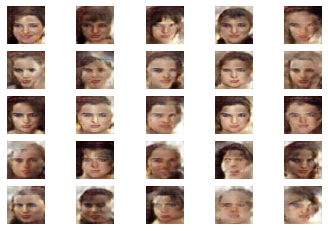

>2, 4687/4687, d1=0.643, d2=0.507 g=2.560


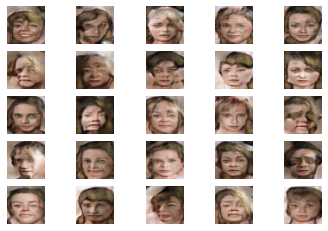

>3, 4687/4687, d1=1.081, d2=0.336 g=2.110


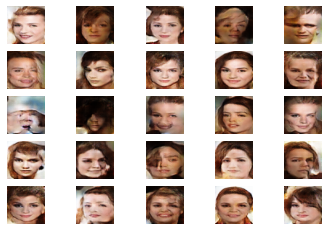

>4, 4687/4687, d1=0.509, d2=0.404 g=1.946


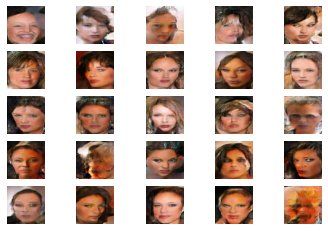

>5, 4687/4687, d1=0.182, d2=0.434 g=2.226


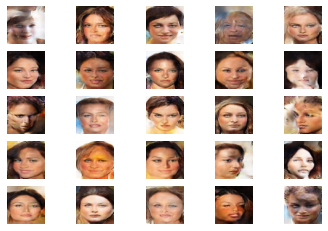

>6, 4687/4687, d1=0.538, d2=0.230 g=2.757


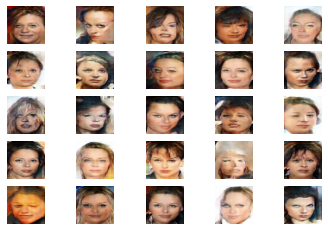

>7, 4687/4687, d1=0.394, d2=0.337 g=1.960


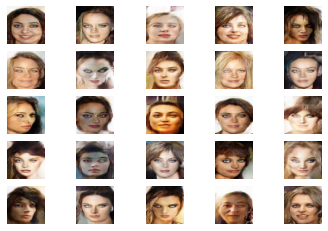

>8, 4687/4687, d1=0.744, d2=0.392 g=2.314


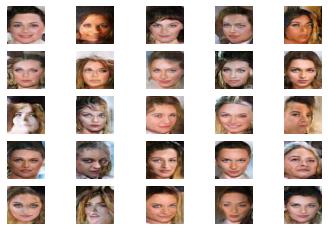

>9, 4687/4687, d1=0.216, d2=0.355 g=2.061


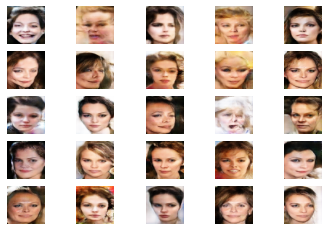

>10, 4687/4687, d1=0.630, d2=0.408 g=2.381


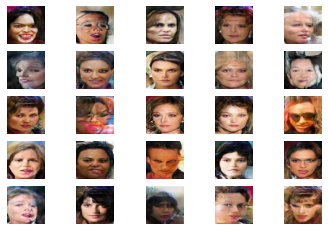

>11, 4687/4687, d1=0.419, d2=0.190 g=2.923


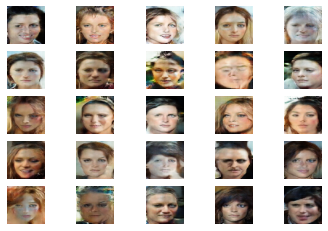

>12, 4687/4687, d1=0.354, d2=0.188 g=2.457


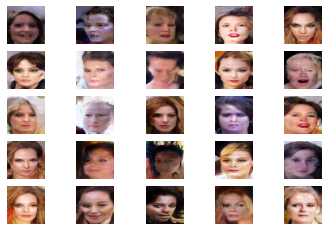

>13, 4687/4687, d1=0.134, d2=0.658 g=4.331


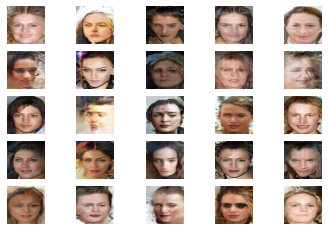

>14, 4687/4687, d1=0.318, d2=0.530 g=3.118


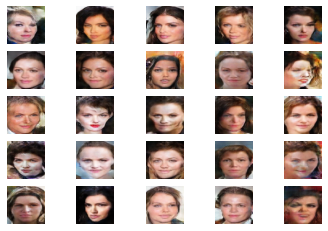

>15, 4687/4687, d1=0.220, d2=0.292 g=3.285


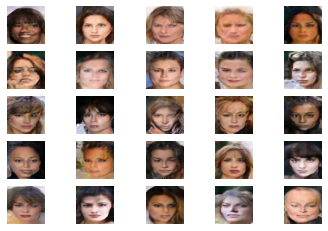

>16, 4687/4687, d1=0.342, d2=0.084 g=3.363


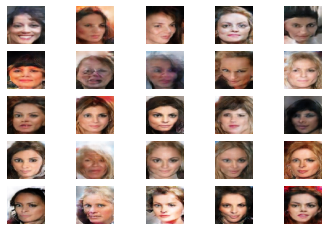

>17, 4687/4687, d1=0.225, d2=0.069 g=3.438


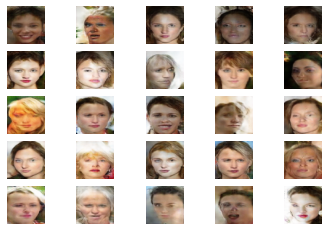

>18, 4687/4687, d1=0.269, d2=0.157 g=3.018


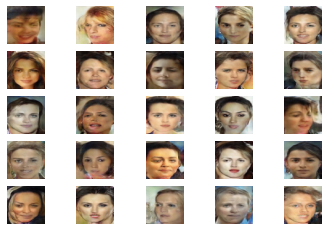

>19, 4687/4687, d1=0.243, d2=0.101 g=2.985


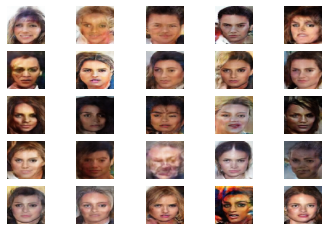

>20, 4687/4687, d1=0.067, d2=0.058 g=3.942


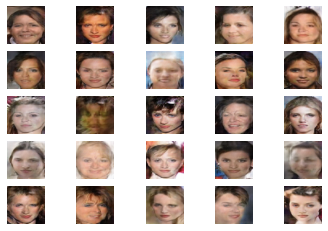

>21, 4687/4687, d1=0.227, d2=0.167 g=3.517


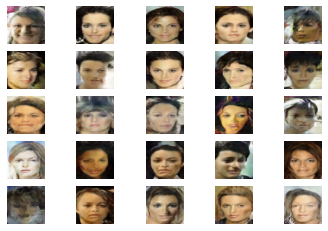

>22, 4687/4687, d1=0.411, d2=0.267 g=3.205


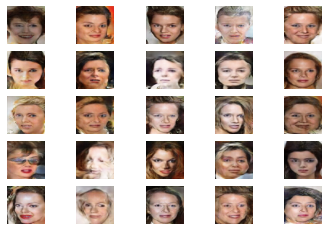

>23, 4687/4687, d1=0.187, d2=0.036 g=3.899


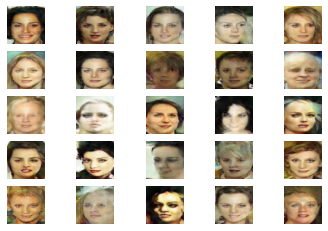

>24, 4687/4687, d1=0.147, d2=0.161 g=3.871


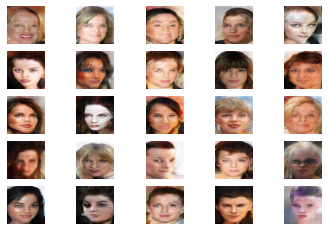

>25, 4687/4687, d1=0.297, d2=0.036 g=4.457


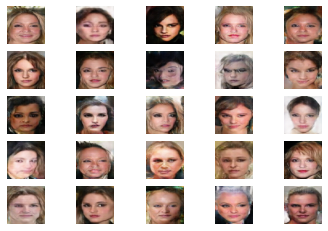

>26, 4687/4687, d1=0.102, d2=0.194 g=3.164


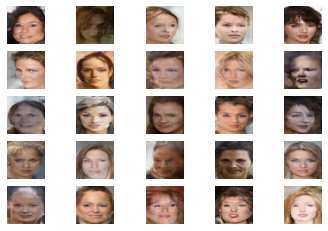

>27, 4687/4687, d1=0.055, d2=0.071 g=3.359


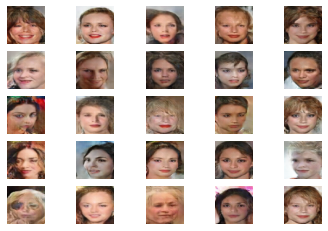

>28, 4687/4687, d1=0.029, d2=0.077 g=4.678


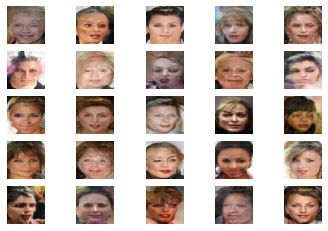

>29, 4687/4687, d1=0.065, d2=0.096 g=3.491


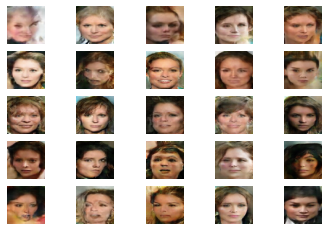

>30, 4687/4687, d1=0.241, d2=0.162 g=2.815


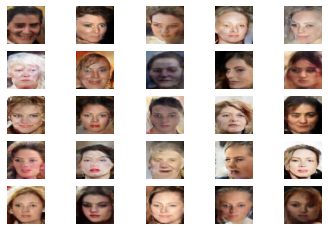

>31, 4687/4687, d1=0.237, d2=0.148 g=3.375


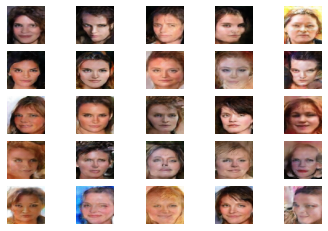

>32, 4687/4687, d1=0.027, d2=0.040 g=4.053


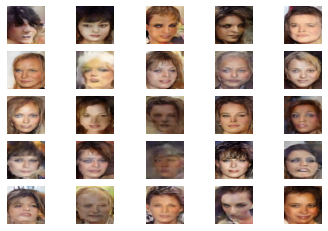

>33, 4687/4687, d1=0.118, d2=0.114 g=4.051


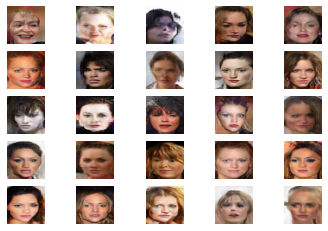

>34, 4687/4687, d1=0.153, d2=0.182 g=3.710


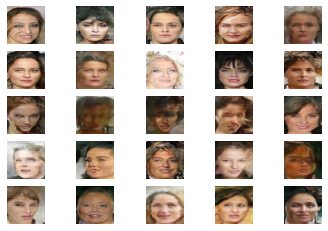

>35, 4687/4687, d1=0.211, d2=0.089 g=3.259


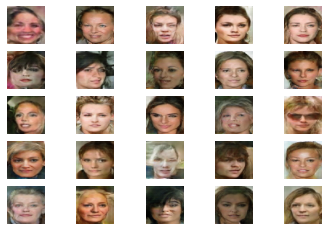

>36, 4687/4687, d1=0.455, d2=0.406 g=3.776


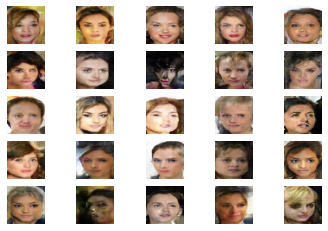

>37, 4687/4687, d1=0.252, d2=0.049 g=3.015


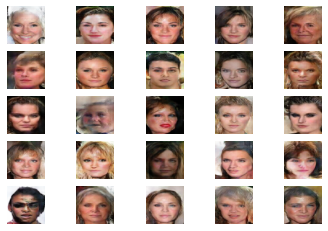

>38, 4687/4687, d1=0.151, d2=0.316 g=3.909


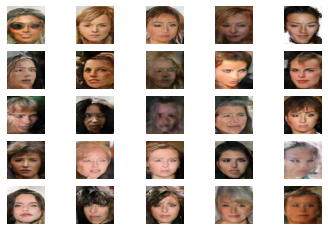

>39, 4687/4687, d1=0.413, d2=0.098 g=3.345


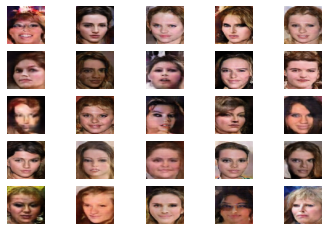

>40, 4687/4687, d1=0.142, d2=0.142 g=4.654


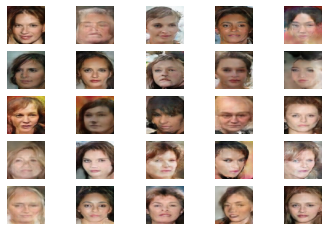

In [13]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim);

In [ ]:
# sirop master thesis / semester proj